In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
import joblib

In [2]:
data = pd.read_csv("CAR DETAILS FROM CAR DEKHO.csv")
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [3]:
data.describe()

,year,selling_price,km_driven
count,4340.000000,4.340000e+03,4340.000000
mean,2013.090783,5.041273e+05,66215.777419
std,4.215344,5.785487e+05,46644.102194
min,1992.000000,2.000000e+04,1.000000
25%,2011.000000,2.087498e+05,35000.000000
50%,2014.000000,3.500000e+05,60000.000000
75%,2016.000000,6.000000e+05,90000.000000
max,2020.000000,8.900000e+06,806599.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'selling_price'}>],
       [<Axes: title={'center': 'km_driven'}>, <Axes: >]], dtype=object)

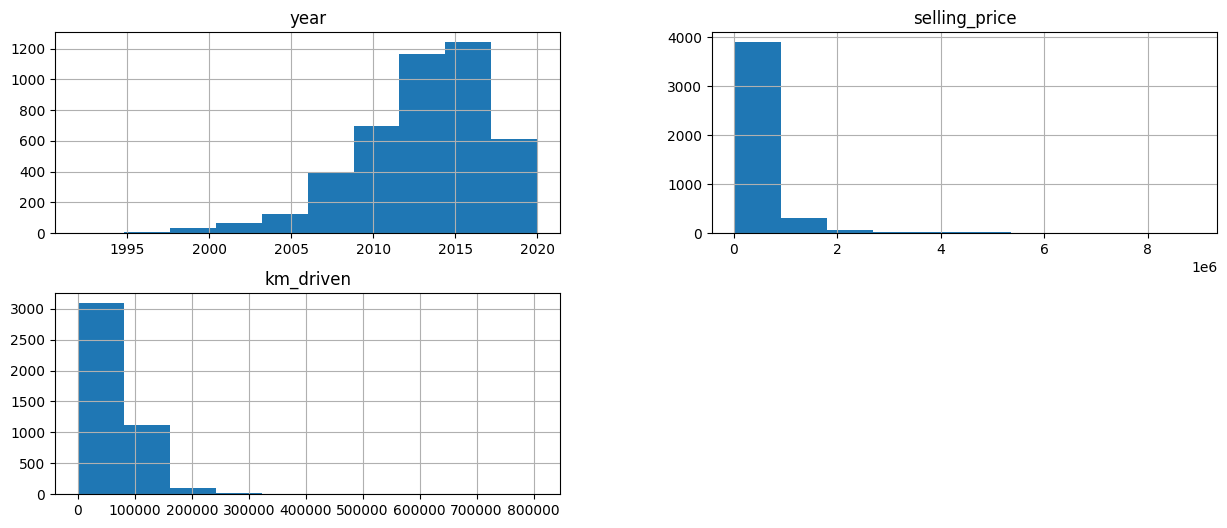

In [5]:
data.hist(figsize=(15,6))

In [6]:
data_new = data.drop(['name'], axis=1)

In [7]:
#Категориальные признаки
df_categorical_features = data_new.select_dtypes(include=[object])

df_categorical_features.columns

Index(['fuel', 'seller_type', 'transmission', 'owner'], dtype='object')

In [8]:
#Числовые признаки
df_numeric_features = data_new.select_dtypes(include=[np.number])

df_numeric_features.columns

Index(['year', 'selling_price', 'km_driven'], dtype='object')

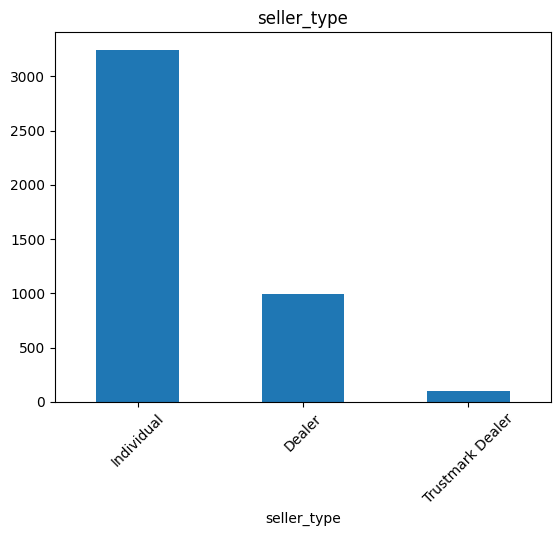

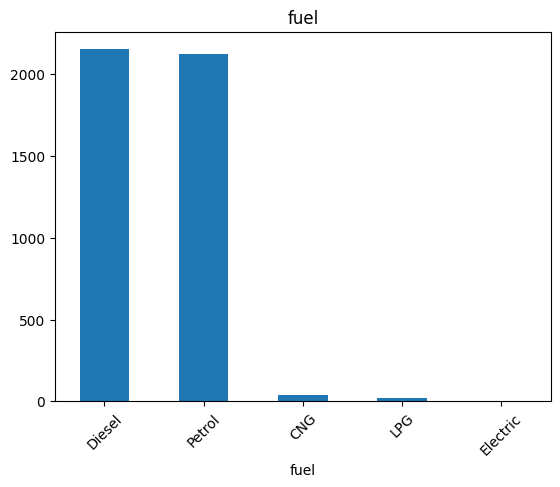

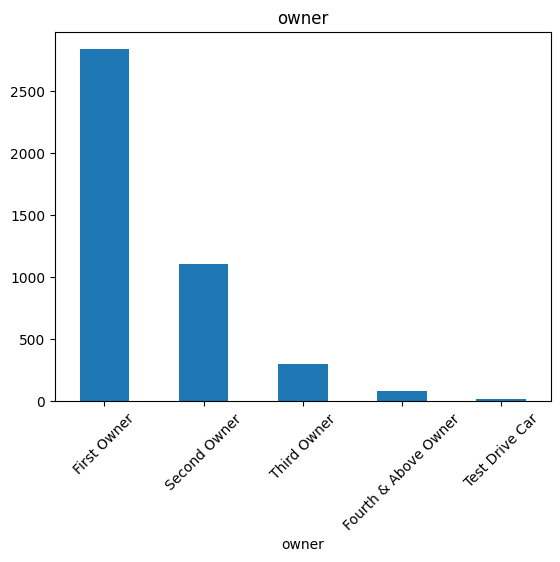

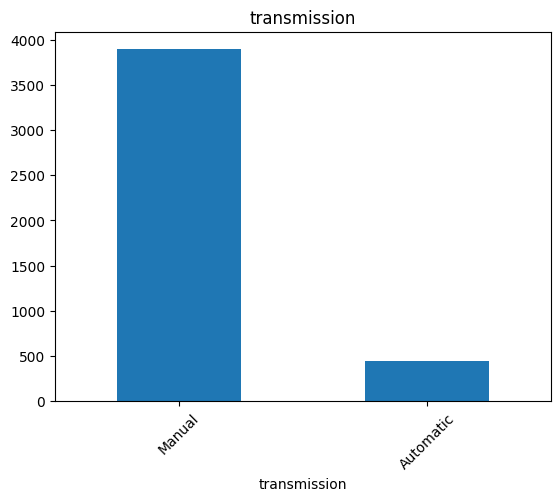

In [9]:
#Диаграмма распределенности типов продавцов
seller_type = ["seller_type"]
fig, ax = plt.subplots(1, len(seller_type))
for i, seller_type in enumerate(data_new[seller_type]):
    data_new[seller_type].value_counts().plot(kind="bar").set_title(seller_type)
plt.xticks(rotation=45)
#plt.yticks(np.arange(0, 45000, 3000.0))
plt.show()

#Диаграмма распределенности типов топлива
fuel = ["fuel"]
fig, ax = plt.subplots(1, len(fuel))
for i, fuel in enumerate(data_new[fuel]):
    data_new[fuel].value_counts().plot(kind="bar").set_title(fuel)
plt.xticks(rotation=45)
#plt.yticks(np.arange(0, 45000, 3000.0))
plt.show()

#Диаграмма распределенности типов владельцев
owner = ["owner"]
fig, ax = plt.subplots(1, len(owner))
for i, owner in enumerate(data_new[owner]):
    data_new[owner].value_counts().plot(kind="bar").set_title(owner)
plt.xticks(rotation=45)
#plt.yticks(np.arange(0, 45000, 3000.0))
plt.show()

#Диаграмма распределенности типов трансмиссии
transmission = ["transmission"]
fig, ax = plt.subplots(1, len(transmission))
for i, transmission in enumerate(data_new[transmission]):
    data_new[transmission].value_counts().plot(kind="bar").set_title(transmission)
plt.xticks(rotation=45)
#plt.yticks(np.arange(0, 45000, 3000.0))
plt.show()

In [10]:
from sklearn.compose import ColumnTransformer

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [11]:
target = data_new['selling_price']
features = data_new.drop(['selling_price'], axis=1)
features["fuel"] = features["fuel"].astype("category")
features["seller_type"] = features["seller_type"].astype("category")
features["transmission"] = features["transmission"].astype("category")
features["owner"] = features["owner"].astype("category")

In [85]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          4340 non-null   int64   
 1   km_driven     4340 non-null   int64   
 2   fuel          4340 non-null   category
 3   seller_type   4340 non-null   category
 4   transmission  4340 non-null   category
 5   owner         4340 non-null   category
dtypes: category(4), int64(2)
memory usage: 85.6 KB


In [109]:
cat_features = list()
for i in features.columns:
    if features[i].dtype != 'int64':
        get_cat = features.columns.get_loc(i)
        cat_features.append(get_cat)
cat_features

[2, 3, 4, 5]

In [110]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=44)

In [111]:
simple_imputer = SimpleImputer(strategy='median')
#std_scaler = StandardScaler()
pipe_num = Pipeline([('imputer', simple_imputer)])

In [112]:
s_imputer = SimpleImputer(strategy='constant', fill_value='unknown')
#cat_proc = features[['fuel', 'seller_type', 'transmission', 'owner']].astype("category")
pipe_cat = Pipeline([('imputer', s_imputer)])

In [113]:
col_transformer = ColumnTransformer([('num_preproc', pipe_num, [x for x in features.columns if features[x].dtype!='category']),
                                     ('cat_preproc', pipe_cat, [x for x in features.columns if features[x].dtype=='category'])])

In [114]:
res = col_transformer.fit_transform(features_train)
res_df = pd.DataFrame(res, columns = [x.split('__')[-1] for x in col_transformer.get_feature_names_out()])
res_df

,year,km_driven,fuel,seller_type,transmission,owner
0,2018.0,10000.0,Petrol,Dealer,Manual,First Owner
1,2005.0,70000.0,Petrol,Individual,Manual,Second Owner
2,2012.0,120000.0,Diesel,Individual,Manual,Second Owner
3,2011.0,40000.0,Petrol,Individual,Manual,Second Owner
4,2016.0,85000.0,Diesel,Individual,Manual,First Owner
...,...,...,...,...,...,...
3467,2009.0,68350.0,Diesel,Dealer,Manual,First Owner
3468,2013.0,1000.0,Diesel,Dealer,Manual,Second Owner
3469,2017.0,10000.0,Petrol,Individual,Manual,First Owner
3470,2019.0,11000.0,Petrol,Individual,Manual,First Owner


In [115]:
model_1 = CatBoostRegressor(cat_features=cat_features, n_estimators=100)

final_pipe = Pipeline([('preproc', col_transformer),
                       ('model', model_1)])

In [116]:
final_pipe.fit(features_train, target_train)
preds = final_pipe.predict(features_test)

Learning rate set to 0.324034
0:	learn: 516140.9777456	total: 155ms	remaining: 15.3s
1:	learn: 466867.5560477	total: 168ms	remaining: 8.22s
2:	learn: 422143.8733342	total: 186ms	remaining: 6s
3:	learn: 393116.8468693	total: 206ms	remaining: 4.95s
4:	learn: 372437.0862827	total: 228ms	remaining: 4.33s
5:	learn: 360845.5927778	total: 246ms	remaining: 3.86s
6:	learn: 354684.2190783	total: 261ms	remaining: 3.47s
7:	learn: 345434.1536192	total: 276ms	remaining: 3.18s
8:	learn: 338027.0007588	total: 291ms	remaining: 2.94s
9:	learn: 334997.2478533	total: 305ms	remaining: 2.75s
10:	learn: 332801.1155534	total: 320ms	remaining: 2.59s
11:	learn: 326393.1328028	total: 334ms	remaining: 2.45s
12:	learn: 325343.6307127	total: 348ms	remaining: 2.33s
13:	learn: 322958.4194371	total: 362ms	remaining: 2.22s
14:	learn: 321972.2294487	total: 376ms	remaining: 2.13s
15:	learn: 320334.4986804	total: 390ms	remaining: 2.05s
16:	learn: 317860.8143326	total: 405ms	remaining: 1.98s
17:	learn: 317688.6386783	total

In [117]:
mse = mean_squared_error(target_test, preds)
rmse = (np.sqrt(mean_squared_error(target_test, preds)))
mae = mean_absolute_error(target_test, preds)
r2 = r2_score(target_test, preds)
print("Оценка тестового множества модели CatBoost:")
print('MSE: {:.2f}'.format(mse))
print('RMSE: {:.2f}'.format(rmse))
print('MAE: {:.2f}'.format(mae))
print('R2: {:.2f}'.format(r2))

Оценка тестового множества модели CatBoost:
MSE: 84726368046.81
RMSE: 291077.94
MAE: 166284.69
R2: 0.74


In [118]:
print(final_pipe.predict(features_test))

[ 382637.12929381  110234.74508517  326891.84011128  536688.9866851
  363061.95626234  335264.8734564   267767.91026191  514728.29054411
  411423.04190383  293600.25388444  403176.50331642  968351.57001209
  476458.89939937  360598.7148969   396160.92582763  135385.90189641
  379832.20458247  149449.64531774  121151.41639996  411423.04190383
  727974.08987302  104963.02959482  462266.4893683   131350.42916951
  452198.43153768  412937.70231061  266831.58285798  127826.20884862
  326891.84011128  528279.16554728  125519.96284693  115027.09768496
  363109.92397726  507015.79819775  192957.78108349  325220.52204751
 2557385.20106208  323463.25415668  851191.97477087  210460.35414875
  402782.00877211  431053.76273996  276113.51637602  589979.31631182
  382637.12929381  347331.58895734  896262.33894201  482167.50297538
  416940.85556055   78650.81081457  159009.18949315  115027.09768496
  644793.93460752  519621.15740484  180979.4430659    72827.81005122
  504150.77524028  682507.15001059 

In [119]:
target_test

2695     250000
1259      75000
2556     114999
3319     700000
2040     110000
         ...   
2368     650000
1558     500000
3565     500000
3284    1500000
2922     170000
Name: selling_price, Length: 868, dtype: int64

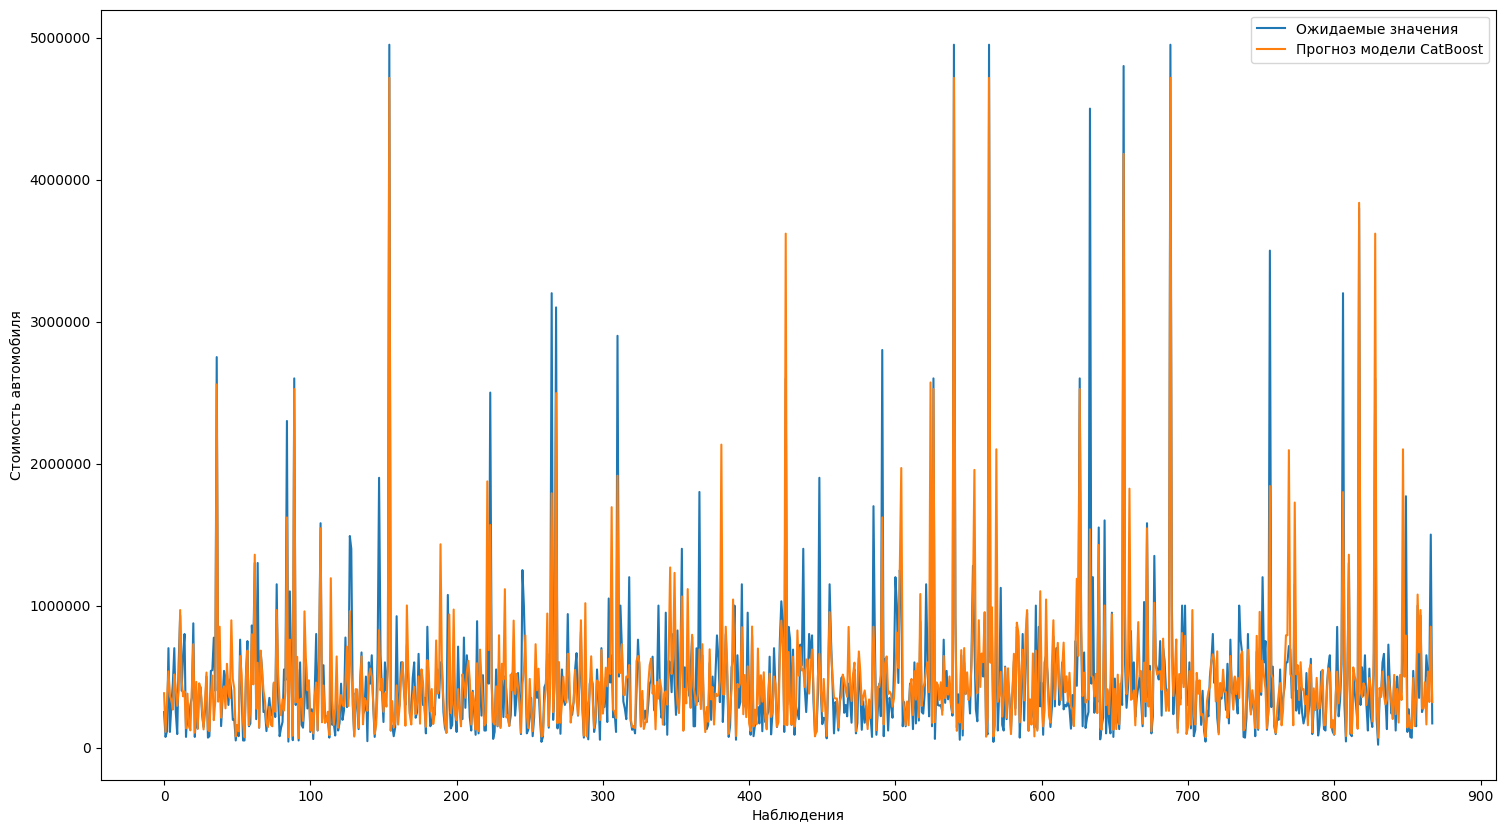

In [120]:
plt.figure(figsize=(18,10))
plt.plot(target_test.values, label = 'Ожидаемые значения')
plt.plot(final_pipe.predict(features_test), label = 'Прогноз модели CatBoost')
plt.xlabel('Наблюдения')
plt.ylabel('Стоимость автомобиля')
plt.ticklabel_format(style='plain')
plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900])
plt.legend()

In [121]:
importances = model_1.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=res_df.columns).sort_values()

In [122]:
print(feature_importances)

owner            0.778856
seller_type      4.803311
km_driven       16.212032
year            17.817753
fuel            18.063175
transmission    42.324874
dtype: float64


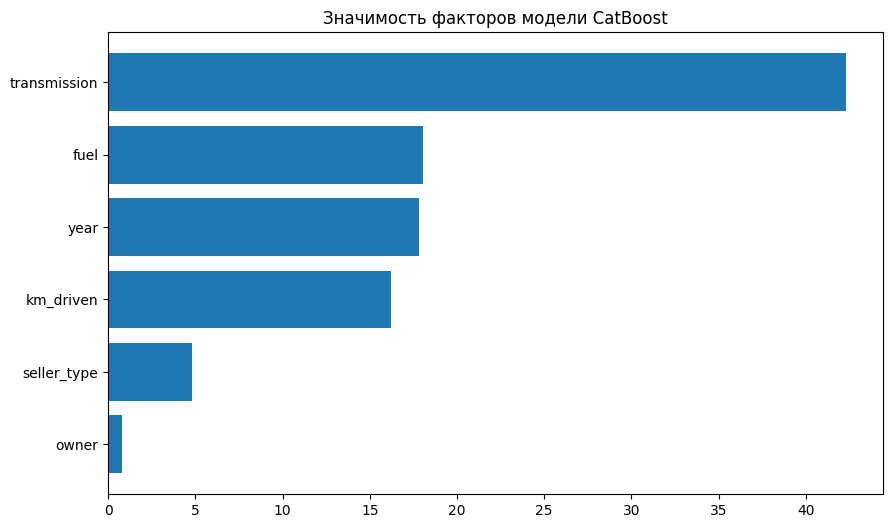

In [123]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('Значимость факторов модели CatBoost')
plt.show()

In [125]:
joblib.dump(model_1, "./model.joblib")

['./model.joblib']